<a href="https://colab.research.google.com/github/himarg2274/HotelRevAI-AI-Driven-Revenue-Analysis-for-Hotels-Team-3-/blob/main/HotelRevAI%20AI%20Driven%20Revenue%20Analysis%20for%20Hotels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Step 0:Data Loading and Cleaning ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2k5tcvyh/hisu_bd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2k5tcvyh/yrvw171h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13428', 'data', 'file=/tmp/tmp2k5tcvyh/hisu_bd9.json', 'init=/tmp/tmp2k5tcvyh/yrvw171h.json', 'output', 'file=/tmp/tmp2k5tcvyh/prophet_model5hbywul0/prophet_model-20250930141442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Dataset loaded and preparation is complete.
Dataset shape: (119386, 40)

--- Step 1: Running Occupancy Forecast (Prophet) ---


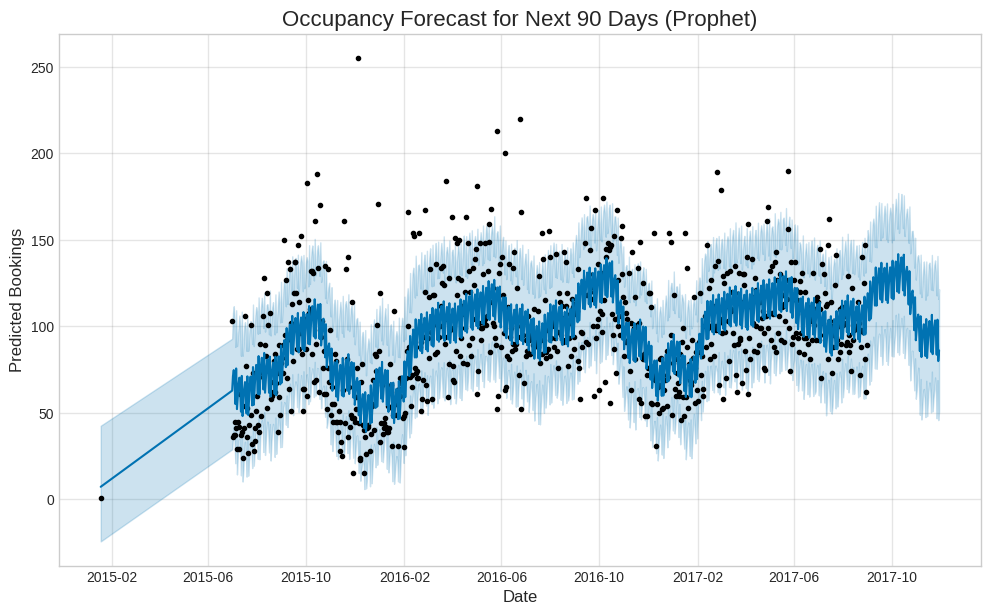

Occupancy forecast complete.

--- Step 2: Running Revenue Forecast (ARIMA) ---


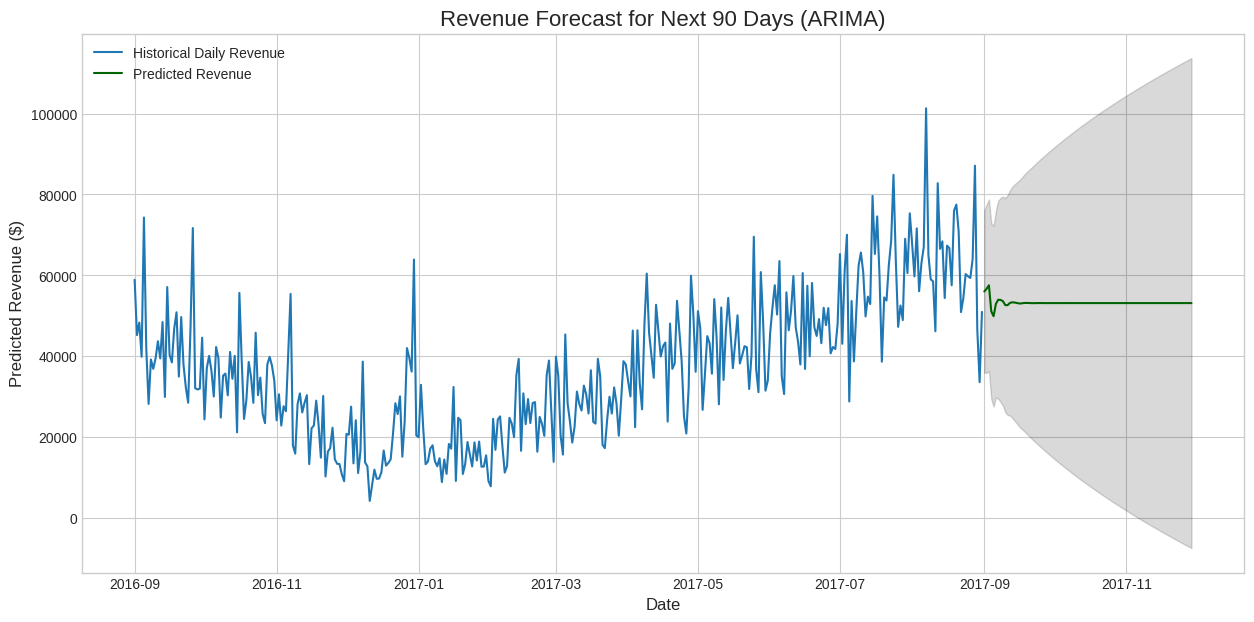

Revenue forecast complete.

--- Step 3: Running Cancellation Prediction Model ---
Cancellation Model Evaluation Report:
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86     22512
         1.0       0.86      0.54      0.67     13303

    accuracy                           0.80     35815
   macro avg       0.82      0.75      0.76     35815
weighted avg       0.81      0.80      0.79     35815

Cancellation prediction complete.

--- Step 4: Exporting All Predictions to CSV ---


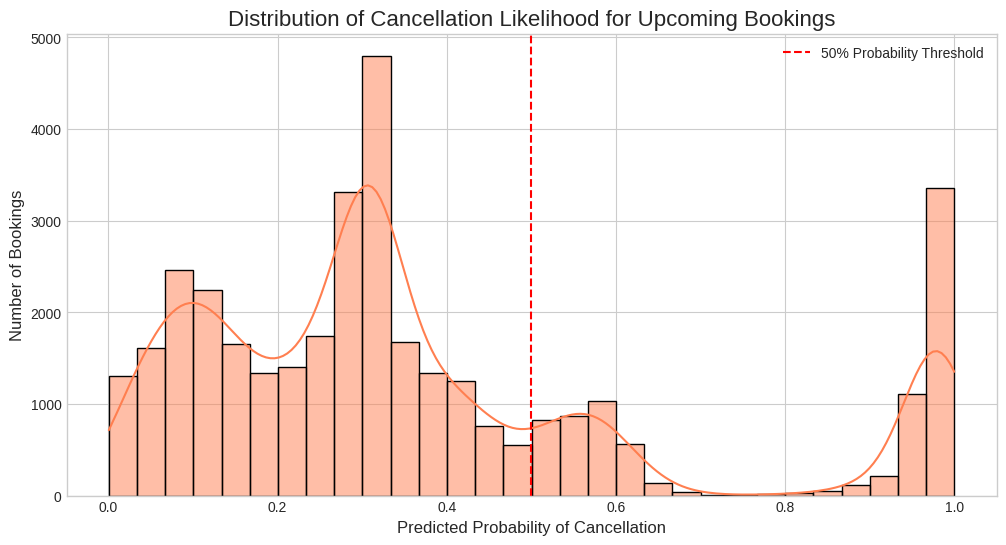


✅ All prediction files have been successfully created:
1. occupancy_forecast.csv
2. revenue_forecast.csv
3. cancellation_predictions.csv


In [ ]:
!pip install prophet pandas numpy scikit-learn xgboost matplotlib seaborn statsmodels -q

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# DATA LOADING AND CLEANING
df = pd.read_csv('hotel_bookings.csv')

print("--- Step 0:Data Loading and Cleaning ---")

# --- Initial Data Cleaning and Preparation (Corrected) ---
# Mapping month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['arrival_date_month_numeric'] = df['arrival_date_month'].map(month_map)

# Fill any potential missing values in date columns with a placeholder (like 0)
date_cols = ['arrival_date_year', 'arrival_date_month_numeric', 'arrival_date_day_of_month']
for col in date_cols:
    df[col] = df[col].fillna(0)

df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(int).astype(str) + '-' +
    df['arrival_date_month_numeric'].astype(int).astype(str) + '-' +
    df['arrival_date_day_of_month'].astype(int).astype(str),
    errors='coerce' # This will turn any invalid dates into 'NaT' (Not a Time)
)

# Drop rows where date conversion failed
df.dropna(subset=['arrival_date'], inplace=True)

# Filter out canceled bookings for occupancy/revenue analysis
df_valid = df[df['is_canceled'] == 0].copy()

print("Dataset loaded and preparation is complete.")
print(f"Dataset shape: {df.shape}\n")

## PART 1: FUTURE OCCUPANCY FORECASTING (PROPHET)

print("--- Step 1: Running Occupancy Forecast (Prophet) ---")

# Prepare data for Prophet ('ds' and 'y' columns)
occupancy_df = df_valid.groupby('arrival_date').size().reset_index(name='y')
occupancy_df.rename(columns={'arrival_date': 'ds'}, inplace=True)

# Build and train the Prophet model
model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
model_prophet.fit(occupancy_df)

# Make future predictions for the next 90 days
future_dates = model_prophet.make_future_dataframe(periods=90)
forecast_prophet = model_prophet.predict(future_dates)

# Visualize the forecast
fig1 = model_prophet.plot(forecast_prophet)
plt.title('Occupancy Forecast for Next 90 Days (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Bookings', fontsize=12)
plt.show()

# Prepare the output file
occupancy_forecast_output = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
occupancy_forecast_output.rename(columns={
    'ds': 'Date', 'yhat': 'Predicted_Occupancy',
    'yhat_lower': 'Occupancy_Lower_Bound', 'yhat_upper': 'Occupancy_Upper_Bound'
}, inplace=True)
print("Occupancy forecast complete.\n")

# PART 2: REVENUE FORECASTING (ARIMA)

print("--- Step 2: Running Revenue Forecast (ARIMA) ---")

# Prepare data for ARIMA
df_valid['total_nights'] = df_valid['stays_in_weekend_nights'] + df_valid['stays_in_week_nights']
df_valid['revenue'] = df_valid['adr'] * df_valid['total_nights']
revenue_df = df_valid.groupby('arrival_date')['revenue'].sum().reset_index()
revenue_ts = revenue_df.set_index('arrival_date')['revenue'].asfreq('D', fill_value=0)

# Build and train the ARIMA model (p,d,q parameters)
model_arima = ARIMA(revenue_ts, order=(5, 1, 0))
arima_fit = model_arima.fit()

# Make future predictions for the next 90 days
forecast_arima = arima_fit.get_forecast(steps=90)
forecast_index = pd.date_range(start=revenue_ts.index[-1] + pd.Timedelta(days=1), periods=90)
predicted_revenue = forecast_arima.predicted_mean
confidence_intervals = forecast_arima.conf_int()

# Visualize the forecast
plt.figure(figsize=(15, 7))
plt.plot(revenue_ts.tail(365), label='Historical Daily Revenue')
plt.plot(forecast_index, predicted_revenue, color='darkgreen', label='Predicted Revenue')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=.15)
plt.title('Revenue Forecast for Next 90 Days (ARIMA)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Revenue ($)', fontsize=12)
plt.legend()
plt.show()

# Prepare the output file
revenue_forecast_output = pd.DataFrame({
    'Date': forecast_index,
    'Predicted_Revenue': predicted_revenue,
    'Revenue_Lower_Bound': confidence_intervals.iloc[:, 0],
    'Revenue_Upper_Bound': confidence_intervals.iloc[:, 1]
})
print("Revenue forecast complete.\n")

## PART 3: CANCELLATION LIKELIHOOD (CLASSIFICATION)

print("--- Step 3: Running Cancellation Prediction Model ---")


features = [
    'lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests',
    'hotel', 'deposit_type', 'customer_type'
]
target = 'is_canceled'

df_model = df.copy()
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model.dropna(subset=features + [target], inplace=True)

# One-hot encode categorical features
df_model = pd.get_dummies(df_model, columns=['hotel', 'deposit_type', 'customer_type'], drop_first=True)
encoded_features = [col for col in df_model.columns if any(c in col for c in features)]

# Split data and train the model
X = df_model[encoded_features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model_rf.fit(X_train, y_train)

# Evaluate the model
y_pred = model_rf.predict(X_test)
print("Cancellation Model Evaluation Report:")
print(classification_report(y_test, y_pred))

# Predict probabilities on the test set (as a proxy for upcoming bookings)
cancellation_prob = model_rf.predict_proba(X_test)[:, 1]

# Prepare the output file
cancellation_output = df.loc[X_test.index].copy()
cancellation_output['Cancellation_Probability'] = cancellation_prob
print("Cancellation prediction complete.\n")

## PART 4: EXPORT ALL PREDICTIONS TO CSV

print("--- Step 4: Exporting All Predictions to CSV ---")

# Export the files
occupancy_forecast_output.to_csv('occupancy_forecast.csv', index=False)
revenue_forecast_output.to_csv('revenue_forecast.csv', index=False)
cancellation_output.to_csv('cancellation_predictions.csv', index=False)
# --- Visualize Cancellation Likelihood Distribution ---

plt.figure(figsize=(12, 6))

# Create a histogram/distribution plot of the predicted probabilities
sns.histplot(data=cancellation_output, x='Cancellation_Probability', kde=True, bins=30, color='coral')

# Add a vertical line at the 50% probability mark to distinguish high/low risk
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Probability Threshold')

plt.title('Distribution of Cancellation Likelihood for Upcoming Bookings', fontsize=16)
plt.xlabel('Predicted Probability of Cancellation', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.legend()
plt.show()

print("\n✅ All prediction files have been successfully created:")
print("1. occupancy_forecast.csv")
print("2. revenue_forecast.csv")
print("3. cancellation_predictions.csv")


In [ ]:
# 1. Install necessary libraries
!pip install streamlit pyngrok -q
import pandas as pd
import os

# 2. Read the dataset you uploaded to Google Colab
# IMPORTANT: Make sure you have uploaded 'hotel_bookings.csv' before running this cell.
try:
    df_check = pd.read_csv("hotel_bookings.csv")
    print("✅ 'hotel_bookings.csv' found and loaded successfully.")
except FileNotFoundError:
    print("❌ ERROR: 'hotel_bookings.csv' not found. Please upload the file to your Colab session before running this script.")

# 3. Define the Streamlit app code as a Python string
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from statsmodels.tsa.arima.model import ARIMA
import warnings

# --- Page Configuration and Style ---
st.set_page_config(
    page_title="Hotel Booking Analysis Dashboard",
    page_icon="🏨",
    layout="wide"
)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# --- Caching Functions for Performance ---
@st.cache_data
def load_data(path):
    df = pd.read_csv(path)
    # Data Cleaning
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['arrival_date_month_numeric'] = df['arrival_date_month'].map(month_map)
    date_cols = ['arrival_date_year', 'arrival_date_month_numeric', 'arrival_date_day_of_month']
    for col in date_cols:
        df[col] = df[col].fillna(0)
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(int).astype(str) + '-' +
        df['arrival_date_month_numeric'].astype(int).astype(str) + '-' +
        df['arrival_date_day_of_month'].astype(int).astype(str),
        errors='coerce'
    )
    df.dropna(subset=['arrival_date'], inplace=True)
    df_valid = df[df['is_canceled'] == 0].copy()
    return df, df_valid

@st.cache_resource
def train_cancellation_model(_df):
    features = [
        'lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
        'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
        'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests',
        'hotel', 'deposit_type', 'customer_type'
    ]
    target = 'is_canceled'
    df_model = _df.copy()
    df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_model.dropna(subset=features + [target], inplace=True)
    df_model = pd.get_dummies(df_model, columns=['hotel', 'deposit_type', 'customer_type'], drop_first=True)
    encoded_features = [col for col in df_model.columns if any(c in col for c in features)]
    X = df_model[encoded_features]
    y = df_model[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    model_rf.fit(X_train, y_train)
    return model_rf, X_test, y_test, _df

# --- Main App ---
st.title("🏨 Hotel Booking Analysis & Forecasting Dashboard")
df, df_valid = load_data('hotel_bookings.csv')

st.sidebar.header("Dashboard Controls")
page = st.sidebar.radio("Select an Analysis:",
                        ("Occupancy Forecast", "Revenue Forecast", "Cancellation Analysis"))

if page == "Occupancy Forecast":
    st.header("Future Occupancy Forecast (Prophet)")
    forecast_days = st.slider("Select forecast days:", 30, 365, 90, key="occupancy_slider")
    occupancy_df = df_valid.groupby('arrival_date').size().reset_index(name='y')
    occupancy_df.rename(columns={'arrival_date': 'ds'}, inplace=True)
    model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
    model_prophet.fit(occupancy_df)
    future_dates = model_prophet.make_future_dataframe(periods=forecast_days)
    forecast_prophet = model_prophet.predict(future_dates)

    st.subheader("Occupancy Forecast Plot")
    fig1 = model_prophet.plot(forecast_prophet)
    st.pyplot(fig1)

    st.subheader("Key Insights")
    forecast_period = forecast_prophet.tail(forecast_days)
    total_bookings = forecast_period['yhat'].sum()
    avg_bookings = forecast_period['yhat'].mean()
    peak_day_row = forecast_period.loc[forecast_period['yhat'].idxmax()]
    peak_date = peak_day_row['ds'].strftime('%B %d, %Y')
    peak_bookings = peak_day_row['yhat']

    st.markdown(
f'''
**Chart Legend:**
- **Black Dots**: Represent the actual, historical daily bookings.
- **Blue Line**: The model's prediction for future bookings.
- **Light Blue Area**: The confidence interval. We are 95% confident that the actual number of bookings will fall within this range.

**Numerical Summary for the Next {forecast_days} Days:**
- **Total Forecasted Bookings:** We project a total of **{total_bookings:,.0f}** new bookings.
- **Average Daily Occupancy:** We expect an average of **{avg_bookings:.0f}** bookings per day.
- **Peak Demand:** The busiest day is forecasted to be **{peak_date}** with **{peak_bookings:.0f}** bookings.
'''
    )

elif page == "Revenue Forecast":
    st.header("Future Revenue Forecast (ARIMA)")
    forecast_days_rev = st.slider("Select forecast days:", 30, 365, 90, key="revenue_slider")
    df_valid['total_nights'] = df_valid['stays_in_weekend_nights'] + df_valid['stays_in_week_nights']
    df_valid['revenue'] = df_valid['adr'] * df_valid['total_nights']
    revenue_ts = df_valid.groupby('arrival_date')['revenue'].sum().asfreq('D', fill_value=0)
    with st.spinner('Training ARIMA model...'):
        model_arima = ARIMA(revenue_ts, order=(5, 1, 0))
        arima_fit = model_arima.fit()
    forecast_arima = arima_fit.get_forecast(steps=forecast_days_rev)
    forecast_index = pd.date_range(start=revenue_ts.index[-1] + pd.Timedelta(days=1), periods=forecast_days_rev)
    predicted_revenue = forecast_arima.predicted_mean
    confidence_intervals = forecast_arima.conf_int()

    st.subheader("Revenue Forecast Plot")
    fig2, ax = plt.subplots(figsize=(15, 7))
    ax.plot(revenue_ts.tail(365), label='Historical Daily Revenue')
    ax.plot(forecast_index, predicted_revenue, color='darkgreen', label='Predicted Revenue')
    ax.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=.15)
    ax.legend()
    st.pyplot(fig2)

    st.subheader("Financial Projections")
    total_revenue = predicted_revenue.sum()
    avg_revenue = predicted_revenue.mean()
    lower_bound_total = confidence_intervals.iloc[:, 0].sum()
    upper_bound_total = confidence_intervals.iloc[:, 1].sum()

    st.markdown(
f'''
**Chart Legend:**
- **Blue Line**: The actual, historical daily revenue.
- **Green Line**: The model's forecast for future revenue.
- **Grey Area**: The 95% confidence interval for the revenue forecast.

**Numerical Summary for the Next {forecast_days_rev} Days:**
- **Projected Total Revenue:** We forecast **${total_revenue:,.2f}**.
- **Average Daily Revenue:** We expect an average of **${avg_revenue:,.2f}** per day.
- **Confidence Range:** The total revenue will likely fall between **${lower_bound_total:,.2f}** and **${upper_bound_total:,.2f}**.
'''
    )

elif page == "Cancellation Analysis":
    st.header("Cancellation Likelihood Analysis")
    with st.spinner('Training classification model...'):
        model_rf, X_test, y_test, df_full = train_cancellation_model(df)

    st.subheader("Distribution of Cancellation Likelihood")
    cancellation_prob = model_rf.predict_proba(X_test)[:, 1]
    cancellation_output = df_full.loc[X_test.index].copy()
    cancellation_output['Cancellation_Probability'] = cancellation_prob
    fig3, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data=cancellation_output, x='Cancellation_Probability', kde=True, bins=30, color='coral', ax=ax)
    ax.axvline(x=0.5, color='red', linestyle='--', label='50% Probability Threshold')
    ax.legend()
    st.pyplot(fig3)

    st.subheader("Cancellation Risk Assessment")
    total_analyzed = len(X_test)
    high_risk_threshold = st.slider("Set high-risk threshold:", 0.50, 1.00, 0.75, 0.05)
    high_risk_bookings = cancellation_output[cancellation_output['Cancellation_Probability'] > high_risk_threshold]
    num_high_risk = len(high_risk_bookings)
    pct_high_risk = (num_high_risk / total_analyzed) * 100 if total_analyzed > 0 else 0

    st.markdown(
f'''
**Chart Legend:**
- **X-axis**: The predicted probability of a booking being canceled (0% to 100%).
- **Y-axis**: The number of bookings in each risk category.
- **Red Line**: A 50% probability threshold for reference.

**Numerical Summary for the {total_analyzed:,} Upcoming Bookings:**
- **High-Risk Bookings:** Using a {high_risk_threshold:.0%} risk threshold, we have identified **{num_high_risk}** bookings (**{pct_high_risk:.1f}%** of the total) that are highly likely to cancel.
- **Recommendation:** Target these **{num_high_risk}** bookings with a proactive engagement campaign to mitigate revenue loss.
'''
    )
    st.dataframe(high_risk_bookings[['arrival_date', 'lead_time', 'adr', 'customer_type', 'Cancellation_Probability']])

    st.subheader("Model Performance")
    y_pred = model_rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    st.dataframe(pd.DataFrame(report).transpose())

"""

# 4. Write the app code to a file
with open('app.py', 'w') as f:
    f.write(app_code)

# 5. Set up the ngrok tunnel and run the Streamlit app
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# ===================================================================
# PASTE YOUR NEW SECRET TOKEN HERE
# Get it from https://dashboard.ngrok.com/get-started/your-authtoken
# ===================================================================
NGROK_AUTH_TOKEN = "33jcg6JVsaygEzWZDtoqNjgbbF8_rDeRWR7wv47YUGVPhM7p"
# ===================================================================

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open a http tunnel on the default streamlit port (8501)
public_url = ngrok.connect(8501)
print(f"🎈 Your Streamlit dashboard is live at: {public_url}")

# Run the app in the background
!streamlit run app.py &>/dev/null&

✅ 'hotel_bookings.csv' found and loaded successfully.
🎈 Your Streamlit dashboard is live at: NgrokTunnel: "https://unstolen-sherron-hierarchically.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
# 1. Install necessary libraries
!pip install streamlit pyngrok -q
import pandas as pd
import os

# 2. IMPORTANT: Upload your 'hotel_bookings.csv' file using the Colab file explorer before running this cell.
print("✅ Libraries installed. Make sure 'hotel_bookings.csv' is uploaded.")

# 3. Define the Streamlit app code as a Python string
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from statsmodels.tsa.arima.model import ARIMA
import warnings

# --- Page Configuration and Style ---
st.set_page_config(
    page_title="Hotel Booking Analysis Dashboard",
    page_icon="🏨",
    layout="wide"
)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# --- Caching Functions for Performance ---
@st.cache_data
def load_data(path):
    df = pd.read_csv(path)
    # Data Cleaning
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['arrival_date_month_numeric'] = df['arrival_date_month'].map(month_map)
    date_cols = ['arrival_date_year', 'arrival_date_month_numeric', 'arrival_date_day_of_month']
    for col in date_cols:
        df[col] = df[col].fillna(0)
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(int).astype(str) + '-' +
        df['arrival_date_month_numeric'].astype(int).astype(str) + '-' +
        df['arrival_date_day_of_month'].astype(int).astype(str),
        errors='coerce'
    )
    df.dropna(subset=['arrival_date'], inplace=True)
    df_valid = df[df['is_canceled'] == 0].copy()
    return df, df_valid

@st.cache_resource
def train_cancellation_model(_df):
    features = [
        'lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies',
        'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
        'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests',
        'hotel', 'deposit_type', 'customer_type'
    ]
    target = 'is_canceled'
    df_model = _df.copy()
    df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_model.dropna(subset=features + [target], inplace=True)
    df_model = pd.get_dummies(df_model, columns=['hotel', 'deposit_type', 'customer_type'], drop_first=True)
    encoded_features = [col for col in df_model.columns if any(c in col for c in features)]
    X = df_model[encoded_features]
    y = df_model[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    model_rf.fit(X_train, y_train)
    return model_rf, X_test, y_test, _df

# --- Main App ---
st.title("🏨 Hotel Booking Analysis & Forecasting Dashboard")
df, df_valid = load_data('hotel_bookings.csv')

st.sidebar.header("Dashboard Controls")
page = st.sidebar.radio("Select an Analysis:",
                        ("Occupancy Forecast", "Revenue Forecast", "Cancellation Analysis"))

if page == "Occupancy Forecast":
    st.header("Future Occupancy Forecast (Prophet)")
    forecast_days = st.slider("Select forecast days:", 30, 365, 90, key="occupancy_slider")
    occupancy_df = df_valid.groupby('arrival_date').size().reset_index(name='y')
    occupancy_df.rename(columns={'arrival_date': 'ds'}, inplace=True)
    model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
    model_prophet.fit(occupancy_df)
    future_dates = model_prophet.make_future_dataframe(periods=forecast_days)
    forecast_prophet = model_prophet.predict(future_dates)

    st.subheader("Occupancy Forecast Plot")
    fig1 = model_prophet.plot(forecast_prophet)
    st.pyplot(fig1)

    st.subheader("Key Insights")
    forecast_period = forecast_prophet.tail(forecast_days)
    total_bookings = forecast_period['yhat'].sum()
    avg_bookings = forecast_period['yhat'].mean()
    peak_day_row = forecast_period.loc[forecast_period['yhat'].idxmax()]
    peak_date = peak_day_row['ds'].strftime('%B %d, %Y')
    peak_bookings = peak_day_row['yhat']

    st.markdown(
f'''
**Chart Legend:**
- **Black Dots**: Represent the actual, historical daily bookings.
- **Blue Line**: The model's prediction for future bookings.
- **Light Blue Area**: The confidence interval. We are 95% confident that the actual number of bookings will fall within this range.

**Numerical Summary for the Next {forecast_days} Days:**
- **Total Forecasted Bookings:** We project a total of **{total_bookings:,.0f}** new bookings.
- **Average Daily Occupancy:** We expect an average of **{avg_bookings:.0f}** bookings per day.
- **Peak Demand:** The busiest day is forecasted to be **{peak_date}** with **{peak_bookings:.0f}** bookings.
'''
    )

elif page == "Revenue Forecast":
    st.header("Future Revenue Forecast (ARIMA)")
    forecast_days_rev = st.slider("Select forecast days:", 30, 365, 90, key="revenue_slider")
    df_valid['total_nights'] = df_valid['stays_in_weekend_nights'] + df_valid['stays_in_week_nights']
    df_valid['revenue'] = df_valid['adr'] * df_valid['total_nights']
    revenue_ts = df_valid.groupby('arrival_date')['revenue'].sum().asfreq('D', fill_value=0)
    with st.spinner('Training ARIMA model...'):
        model_arima = ARIMA(revenue_ts, order=(5, 1, 0))
        arima_fit = model_arima.fit()
    forecast_arima = arima_fit.get_forecast(steps=forecast_days_rev)
    forecast_index = pd.date_range(start=revenue_ts.index[-1] + pd.Timedelta(days=1), periods=forecast_days_rev)
    predicted_revenue = forecast_arima.predicted_mean
    confidence_intervals = forecast_arima.conf_int()

    st.subheader("Revenue Forecast Plot")
    fig2, ax = plt.subplots(figsize=(15, 7))
    ax.plot(revenue_ts.tail(365), label='Historical Daily Revenue')
    ax.plot(forecast_index, predicted_revenue, color='darkgreen', label='Predicted Revenue')
    ax.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=.15)
    ax.legend()
    st.pyplot(fig2)

    st.subheader("Financial Projections")
    total_revenue = predicted_revenue.sum()
    avg_revenue = predicted_revenue.mean()
    lower_bound_total = confidence_intervals.iloc[:, 0].sum()
    upper_bound_total = confidence_intervals.iloc[:, 1].sum()

    st.markdown(
f'''
**Chart Legend:**
- **Blue Line**: The actual, historical daily revenue.
- **Green Line**: The model's forecast for future revenue.
- **Grey Area**: The 95% confidence interval for the revenue forecast.

**Numerical Summary for the Next {forecast_days_rev} Days:**
- **Projected Total Revenue:** We forecast **${total_revenue:,.2f}**.
- **Average Daily Revenue:** We expect an average of **${avg_revenue:,.2f}** per day.
- **Confidence Range:** The total revenue will likely fall between **${lower_bound_total:,.2f}** and **${upper_bound_total:,.2f}**.
'''
    )

elif page == "Cancellation Analysis":
    st.header("Cancellation Likelihood Analysis")
    with st.spinner('Training classification model...'):
        model_rf, X_test, y_test, df_full = train_cancellation_model(df)

    st.subheader("Distribution of Cancellation Likelihood")
    cancellation_prob = model_rf.predict_proba(X_test)[:, 1]
    cancellation_output = df_full.loc[X_test.index].copy()
    cancellation_output['Cancellation_Probability'] = cancellation_prob
    fig3, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data=cancellation_output, x='Cancellation_Probability', kde=True, bins=30, color='coral', ax=ax)
    ax.axvline(x=0.5, color='red', linestyle='--', label='50% Probability Threshold')
    ax.legend()
    st.pyplot(fig3)

    st.subheader("Cancellation Risk Assessment")
    total_analyzed = len(X_test)
    high_risk_threshold = st.slider("Set high-risk threshold:", 0.50, 1.00, 0.75, 0.05)
    high_risk_bookings = cancellation_output[cancellation_output['Cancellation_Probability'] > high_risk_threshold]
    num_high_risk = len(high_risk_bookings)
    pct_high_risk = (num_high_risk / total_analyzed) * 100 if total_analyzed > 0 else 0

    st.markdown(
f'''
**Chart Legend:**
- **X-axis**: The predicted probability of a booking being canceled (0% to 100%).
- **Y-axis**: The number of bookings in each risk category.
- **Red Line**: A 50% probability threshold for reference.

**Numerical Summary for the {total_analyzed:,} Upcoming Bookings:**
- **High-Risk Bookings:** Using a {high_risk_threshold:.0%} risk threshold, we have identified **{num_high_risk}** bookings (**{pct_high_risk:.1f}%** of the total) that are highly likely to cancel.
- **Recommendation:** Target these **{num_high_risk}** bookings with a proactive engagement campaign to mitigate revenue loss.
'''
    )
    st.dataframe(high_risk_bookings[['arrival_date', 'lead_time', 'adr', 'customer_type', 'Cancellation_Probability']])

    st.subheader("Model Performance")
    y_pred = model_rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    st.dataframe(pd.DataFrame(report).transpose())

"""

# 4. Write the app code to a file
with open('app.py', 'w') as f:
    f.write(app_code)

# 5. Set up the ngrok tunnel and run the Streamlit app
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# ===================================================================
# PASTE YOUR NEW SECRET TOKEN HERE
# Get it from https://dashboard.ngrok.com/get-started/your-authtoken
# ===================================================================
NGROK_AUTH_TOKEN = "33jcg6JVsaygEzWZDtoqNjgbbF8_rDeRWR7wv47YUGVPhM7p"
# ===================================================================

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open a http tunnel on the default streamlit port (8501)
public_url = ngrok.connect(8501)
print(f"🎈 Your Streamlit dashboard is live at: {public_url}")

# Run the app in the background
!streamlit run app.py &>/dev/null&

✅ Libraries installed. Make sure 'hotel_bookings.csv' is uploaded.
🎈 Your Streamlit dashboard is live at: NgrokTunnel: "https://unstolen-sherron-hierarchically.ngrok-free.dev" -> "http://localhost:8501"
